# Twitch API Request Test
---
Twitch API Docs : [Twitch Developers] (https://dev.twitch.tv/docs/v5) <br>
Twitch API Client : [Twitch Developers Console] (https://dev.twitch.tv/console/apps) <br>
Twitch API Video Obj : [Twitch API Video Reference] (https://dev.twitch.tv/docs/api/reference#get-videos) <br>
Test Live Video : [MonsterRAT 11/03 Broadcast](https://www.twitch.tv/videos/796905990) 

In [3]:
import requests
import json
import sys

In [4]:
videoID = "796905990"
clientID = "k8tbrzzuqt746l6zq8wqdbcad06tb0"

params = dict({"client_id":clientID})

In [5]:
import numpy as np
import pandas as pd

## 1. Get Json From Twitch API , Save As DataFrame
---
DataFrame to CSV : [Pandas Reference] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) <br>
DataFrame to CSV Encoding : [한글 깨짐 오류 해결] (https://dolhani.tistory.com/521) <br>

In [5]:
chat_log = pd.DataFrame(columns=["Time","User","Chat"])
chat_index = 0

while True:
    if chat_index == 0:
        URL = "https://api.twitch.tv/v5/videos/" + videoID + "/comments?content_offset_seconds=0"
        chat_index += 1
    else:
        URL = "https://api.twitch.tv/v5/videos/" + videoID + "/comments?cursor="
        URL += nextCursor
    
    response = requests.get(URL, params=params)
    data = json.loads(response.text)

    # Make Series
    for idx in range(len(data["comments"])):
        Time = data["comments"][idx]["created_at"][11:19]
        User = data["comments"][idx]["commenter"]["display_name"]
        Chat = data["comments"][idx]["message"]["body"]
        # Append in DataFrame
        log = pd.Series({"Time":Time, "User":User, "Chat":Chat})
        chat_log = chat_log.append(log, ignore_index=True)

    if "_next" not in data.keys():
        break
    nextCursor = data["_next"]

In [6]:
chat_log.to_csv("chat_log.csv", index=False, encoding="utf-8-sig")

## 2. Load Chat Log from CSV
---
Read CSV : [Pandas Reference] (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) <br>

In [6]:
chat_log = pd.read_csv("chat_log.csv", encoding="utf-8-sig")
chat_log.head()

,Time,User,Chat
0,08:13:56,철용곽,켯다
1,08:13:57,따다단따단,뭐긴 물쥐 팬이다
2,08:13:57,jjigijoy,어이 장씨 큐가리고 돌리는거 뭐냐구 ㅋㅋㅋㅋㅋㅋㅋㅋ
3,08:13:57,l_v999,안뇽
4,08:14:06,tptd,마지막 불꽃 가보자...


## 3. Extract Important Words
---
Python Word Cloud : [KonlpyTwitter, Counter] (https://imworld.tistory.com/59) <br>

In [7]:
from collections import Counter
from konlpy.tag import Twitter

In [8]:
# Merge Chat Log with String and Save as TXT File
with open("chat_string.txt", mode="w", encoding="utf-8-sig") as chat_string:
    chat_content = ""
    for idx, chat in enumerate(chat_log["Chat"]):
        chat_content += chat + '\n'

    chat_string.writelines(chat_content)

In [9]:
# Open Txt File
chat_string = open("chat_string.txt", mode="r", encoding="utf-8-sig")
chat_list = chat_string.readlines()
chat_string.close()

In [10]:
# Analyze Words Morphs (형태소 분석)
twitter = Twitter()
morphs = list()

for sentence in chat_list:
    morphs.append(twitter.pos(sentence))

In [11]:
# Extract Words
extracted_words = list()

for sentence in morphs:
    for word, tag in sentence:
        if ((tag not in "Foreign") or (tag not in "Josa") or (tag not in "Alpha") or (tag not in "KoreanParticle") or (tag not in "Punctuation")) and ('\n' not in word) and (tag in "Adjective"):
            extracted_words.append(word)

In [12]:
count = Counter(extracted_words)
words = dict(count.most_common())

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib
from IPython.display import set_matplotlib_formats

matplotlib.rc("font", family="Malgun Gothic")
set_matplotlib_formats("retina")
matplotlib.rc("axes", unicode_minus=False)

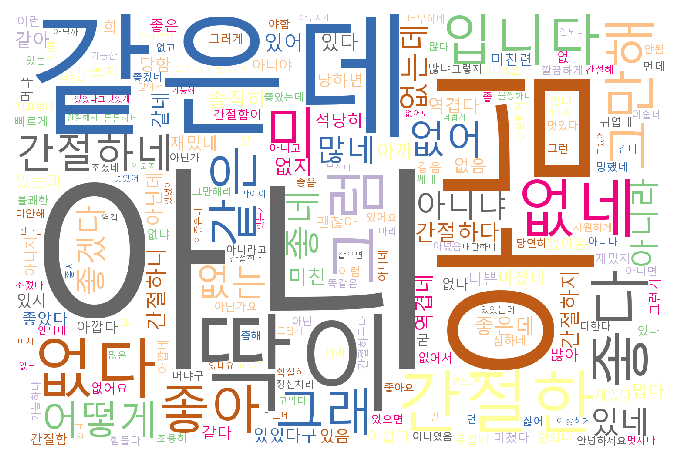

In [14]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(words)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 4. Analysis Funny Reactions
---
Count 'ㅋ' Character per Minute <br>

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [51]:
time_list = np.array(chat_log["Time"])
chat_list = np.array(chat_log["Chat"])

In [52]:
x = list([0])
y = list([0])

for chat, time in zip(chat_list, time_list):
    if x[-1] != time[0:-3]:
        x.append(time[0:-3])
        y.append(0)
    y[len(x)-1] += chat.count('ㅋ')

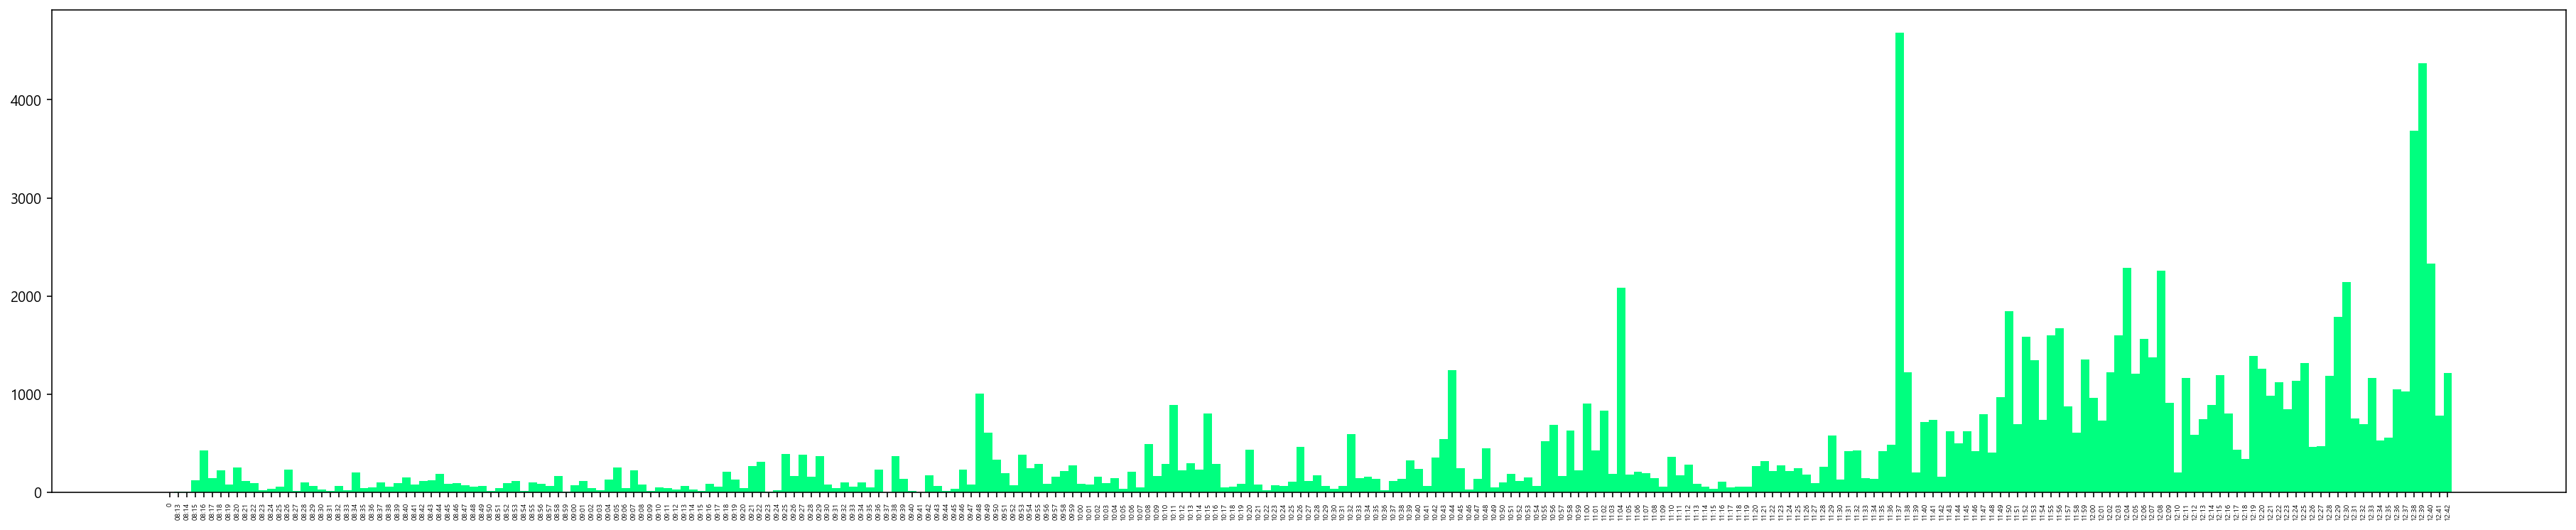

In [56]:
# Plot : Funny Reactions
x_fr = np.array(x)
y_fr = np.array(y)

plt.figure(figsize=(25,5))
plt.bar(np.arange(x_fr.size), y_fr, color="springgreen", width=1) # (arrange, y_values)
plt.xticks(np.arange(y_fr.size), x_fr, fontsize=5, rotation=90)

plt.tight_layout(pad=0.05)
plt.savefig("FunnyReactions.png")

## 5. Analysis Chat Per Minute
---
Get Chat Per Minute <br>

In [15]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [16]:
time_list = np.array(chat_log["Time"])
chat_list = np.array(chat_log["Chat"])

In [22]:
# Create X, Y Array
x = list([0])
y = list([0])

for chat, time in zip(chat_list, time_list):
    if x[-1] != time[0:-3]:
        x.append(time[0:-3])
        y.append(0)
    y[len(x)-1] += 1

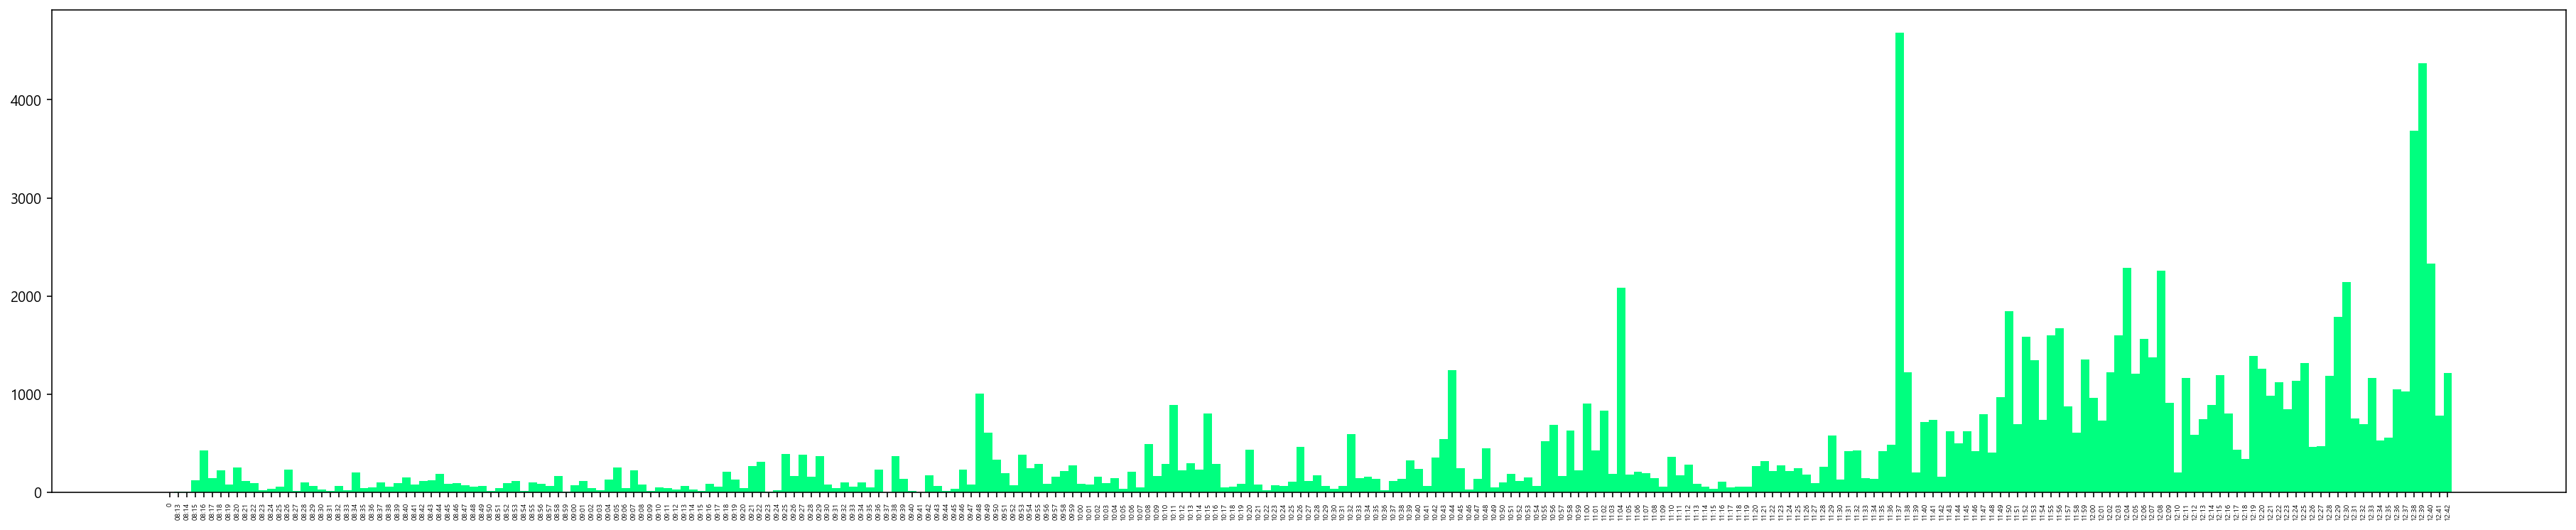

In [57]:
# Plot : Chat Per Minute
x_cpm = np.array(x)
y_cpm = np.array(y)

plt.figure(figsize=(25,5))
plt.bar(np.arange(x_cpm.size), y_cpm, color="springgreen", width=1) # (arrange, y_values)
plt.xticks(np.arange(x_cpm.size), x_cpm, fontsize=5, rotation=90)

plt.tight_layout(pad=0.05)
plt.savefig("ChatPerMinute.png")

## 6. Interpolation
---
보간법(Interpolation) : 알려진 데이터 지점의 고립점 내에서 새로운 데이터 지점을 구성하는 방식
